In [1]:
## CNN classifier for arming the edge

In [1]:
import tensorflow as tf
import numpy as np

from glob import glob
from keras_unet.models import custom_unet
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Add, Activation, Concatenate, Flatten
from tensorflow.keras.layers import Cropping2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, Dropout, Reshape
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from PIL import Image
from random import shuffle

import matplotlib.image as mpimg
import os


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"  

%pylab inline

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Populating the interactive namespace from numpy and matplotlib


/homes/rjackson/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Crop white space out of all images if not already done

In [2]:
raw_images = '/lambda_stor/data/rjackson/lidar_pngs/5min/**/*.png'
raw_img_list = glob(raw_images, recursive=True)
print(len(raw_img_list))

22605


In [14]:
for image_file in raw_img_list:
    yourImage = Image.open(image_file)
    yourImage.crop((130, 40, 1320, 410)).save(image_file)

## Augment training images for cloudy by doing a left-right flip, same for rain

In [2]:
cloudy_data_path = '/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training/clear/*.png'
cloud_images = glob(cloudy_data_path)
print(len(cloud_images))

7854


In [4]:
train_datagen_flip = ImageDataGenerator(rescale=1/255., 
                                        horizontal_flip=True, 
                                        width_shift_range=[-5, 5])
j = 0
for image in cloud_images:
    img = load_img(image)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) 

    i = 0
    for batch in train_datagen_flip.flow(x, batch_size=1,
                                        save_to_dir='/lambda_stor/data/rjackson/lidar_pngs/augmented/clear/',
                                        save_prefix=str(j) + str(i), save_format='png'):
        i += 1
        if i > 5:
            break
    
    j += 1
    if j % 100 == 0:
        print('%d/%d' % (j, len(cloud_images)))

100/7854
200/7854
300/7854
400/7854
500/7854
600/7854
700/7854
800/7854
900/7854
1000/7854
1100/7854
1200/7854
1300/7854
1400/7854
1500/7854
1600/7854
1700/7854
1800/7854
1900/7854
2000/7854
2100/7854
2200/7854
2300/7854
2400/7854
2500/7854
2600/7854
2700/7854
2800/7854
2900/7854
3000/7854
3100/7854
3200/7854
3300/7854
3400/7854
3500/7854
3600/7854
3700/7854
3800/7854
3900/7854
4000/7854
4100/7854
4200/7854
4300/7854
4400/7854
4500/7854
4600/7854
4700/7854
4800/7854
4900/7854
5000/7854
5100/7854
5200/7854
5300/7854
5400/7854
5500/7854
5600/7854
5700/7854
5800/7854
5900/7854
6000/7854
6100/7854
6200/7854
6300/7854
6400/7854
6500/7854
6600/7854
6700/7854
6800/7854
6900/7854
7000/7854
7100/7854
7200/7854
7300/7854
7400/7854
7500/7854
7600/7854
7700/7854
7800/7854


In [ ]:
train_datagen_flip = ImageDataGenerator(rescale=1/255., 
                                        horizontal_flip=True, 
                                        brightness_range=[0.95, 1.05], width_shift_range=[-5, 5])
j = 0
fig, ax = plt.subplots(6, 6, figsize=(15, 20))
image = cloud_images[0]
img = load_img(image)
x = img_to_array(img)
x = x.reshape((1,) + x.shape) 

i = 0
j = 0
for batch in train_datagen_flip.flow(x, batch_size=1):
    ax[i, j].imshow(batch[0])
    i = i + 1
    if i >= 6:
        j = j + 1
        i = 0
    if j >= 6:
        break

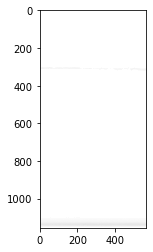

(1155, 566, 4)


In [33]:
img=mpimg.imread('/lambda_stor/data/rjackson/lidar_pngs/5min/training/cloudy/sgpdlacfC1.a1.20170924.220114.moments11.png')
imgplot = plt.imshow(img)
plt.show()
print(img.shape)
# (150, 50), (1300, 400)

In [3]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min/training',
                                                    class_mode='categorical', classes=['clear', 'cloudy', 'rain'],
                                                    target_size=(256, 128), shuffle=True, batch_size=16)
plt.imshow()

Found 0 images belonging to 3 classes.


TypeError: imshow() missing 1 required positional argument: 'X'

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_datagen_flip = ImageDataGenerator(rescale=1/255., horizontal_flip=True, width_shift_range=5)

In [5]:
train_generator = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min_snr/training',
                                                    class_mode='categorical', classes=['clear', 'cloudy', 'rain'],
                                                    target_size=(256, 128), shuffle=True, batch_size=32)
valid_generator = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min_snr/validation',
                                                    class_mode='categorical', classes=['clear', 'cloudy', 'rain'],
                                                    target_size=(256, 128), shuffle=True, batch_size=32)
train_generator_flip = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min_undersample/training',
                                                    class_mode='categorical', classes=['clear', 'cloudy', 'rain'],
                                                    target_size=(256, 128), batch_size=32)
#valid_generator_flip = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/augmented/',
#                                                    class_mode='categorical', classes=['clear', 'cloudy', 'rain'],
#                                                    target_size=(512, 128), batch_size=32)

Found 10740 images belonging to 3 classes.
Found 2784 images belonging to 3 classes.
Found 5938 images belonging to 3 classes.


In [9]:
def resnet(IMG_HEIGHT=256, IMG_WIDTH=128):
    restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
    restnet.summary()
    output = restnet.layers[-1].output
    output = Flatten()(output)
    restnet = Model(restnet.input,output)
    for layer in restnet.layers[:-4]:
        layer.trainable = False
    model = Sequential()
    model.add(restnet)
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, name='targets',
                    activation='softmax',
                    kernel_initializer='he_normal'))
    return model

def vgg(IMG_HEIGHT=256, IMG_WIDTH=128):
    restnet = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
    restnet.summary()
    output = restnet.layers[-1].output
    output = Flatten()(output)
    restnet = Model(restnet.input,output)
    for layer in restnet.layers[:-4]:
        layer.trainable = False
    model = Sequential()
    model.add(restnet)
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, name='targets',
                    activation='softmax',
                    kernel_initializer='he_normal'))
    return model

In [6]:
def conv_net_layer(inp, skip=False, num_channels=2, batch_norm=True,
                   activate=True, add_layer=None):
    x = Conv2D(num_channels, kernel_size=(2, 2), kernel_initializer='he_normal', padding='same',
              kernel_regularizer=l2(0.01))(inp)
    x = Conv2D(num_channels, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same',
              kernel_regularizer=l2(0.01))(x)
    if batch_norm:
        x = Dropout(0.3)(x)
    if activate:
        if add_layer is True:
            x = Add()([x, inp])
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)
    return x

def conv_net_layer_up(inp, skip=False, num_channels=2, batch_norm=True,
                      activate=True, add_layer=None):
    x = Conv2D(1, kernel_size=(3, 3), kernel_initializer='he_normal')(inp)
    x = Conv2D(num_channels, kernel_size=(3, 3), kernel_initializer='he_normal')(x)
    x = Conv2D(3, kernel_size=(3, 3), kernel_initializer='he_normal')(x)
    if batch_norm:
        x = Dropout(0.3)(x)
    if activate:
        if add_layer is not None:
            x = Add()([x, inp])
        x = Activation('relu')(x)
        x = UpSampling2D((2, 2))(x)
    return x

def conv_net_classifier(velocity=False):
    ref_inp = Input(shape=(256, 128, 3), name='snr')
          
    layer2 = conv_net_layer(ref_inp, num_channels=16, batch_norm=True,
             activate=True, add_layer=False)
    layer2 = conv_net_layer(layer2, num_channels=16, batch_norm=True,
             activate=True, add_layer=False)
    layer2 = conv_net_layer(layer2, num_channels=16, batch_norm=True,
             activate=True, add_layer=False)
    layer2 = conv_net_layer(layer2, num_channels=16, batch_norm=True,
             activate=True, add_layer=False)
    layer2 = conv_net_layer(layer2, num_channels=16, batch_norm=True,
             activate=True, add_layer=False)
    ref_out = conv_net_layer(layer2, num_channels=16, add_layer=False, batch_norm=True, activate=False)
    #ref_skip = Activation('relu')(ref_skip)
    #ref_out = Add()([ref_out, ref_skip])
    #ref_out = Activation('relu')(ref_out)
    if velocity:   
        x = Concatenate()([ref_out, vel_out])
    else:
        x = ref_out 
    
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = Flatten()(x)
    #x = AveragePooling2D()(x)
    outputs = Dense(32, activation='relu')(x)
    outputs = Dropout(0.3)(outputs)
    outputs = Dense(32, activation='relu')(outputs)
    outputs = Dropout(0.3)(outputs)
    outputs = Dense(32, activation='relu')(outputs)
    outputs = Dropout(0.3)(outputs)
    outputs = Dense(3, name='targets',
                    activation='softmax',
                    )(outputs)

    #x = Dense(2, activation='relu')(x)
    #x = Dense(3, activation='softmax', name='label')(x)
    if velocity:
        return Model(inputs=[ref_in, vel_in], outputs=outputs)
    else:
        return Model(ref_inp, outputs)

def combine_generator(gen1, gen2):
    while True:
        yield(next(gen1), next(gen2))

In [14]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [10]:
model = vgg()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 64, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 64, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 64, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 32, 128)       0     

In [ ]:
class_weight = {0: 1.,
                1: 3.,
                2: 5.}
checkpointer = ModelCheckpoint(
               filepath=('/homes/rjackson/arming_the_edge/models/res-combined-1layer-{epoch:03d}.hdf5'),
               verbose=1)
early_stopping = EarlyStopping(restore_best_weights=True, patience=100, monitor="val_accuracy", mode="max")
history = model.fit(train_generator, validation_data=valid_generator, epochs=2000,
          callbacks=[checkpointer, early_stopping], initial_epoch=0)

Epoch 1/2000
336/336 [==============================] - 21s 60ms/step - loss: 0.5003 - accuracy: 0.8820 - val_loss: 0.3155 - val_accuracy: 0.8904

Epoch 00001: saving model to /homes/rjackson/arming_the_edge/models/vgg19-combined-1layer-001.hdf5
Epoch 2/2000
336/336 [==============================] - 20s 59ms/step - loss: 0.3044 - accuracy: 0.9003 - val_loss: 0.2950 - val_accuracy: 0.8991

Epoch 00002: saving model to /homes/rjackson/arming_the_edge/models/vgg19-combined-1layer-002.hdf5
Epoch 3/2000
336/336 [==============================] - 20s 60ms/step - loss: 0.3181 - accuracy: 0.8990 - val_loss: 0.3163 - val_accuracy: 0.8804

Epoch 00003: saving model to /homes/rjackson/arming_the_edge/models/vgg19-combined-1layer-003.hdf5
Epoch 4/2000
336/336 [==============================] - 20s 59ms/step - loss: 0.2964 - accuracy: 0.9036 - val_loss: 0.3106 - val_accuracy: 0.8883

Epoch 00004: saving model to /homes/rjackson/arming_the_edge/models/vgg19-combined-1layer-004.hdf5
Epoch 5/2000
336

In [13]:
labels_predict = model.predict(valid_generator)
labels_train = model.predict(train_generator)

In [12]:
model = load_model('/homes/rjackson/arming_the_edge/models/vgg19-combined-1layer-070.hdf5')

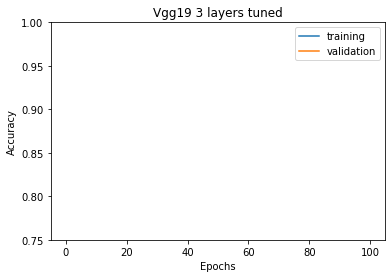

In [39]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.legend()
plt.title('Vgg19 3 layers tuned')
plt.savefig('Vgg193layers.png')

Layerwise relevance propogation

In [8]:
model.layers

In [15]:
xs = []
ys = []
for i in range(10):
    x, y = valid_generator.next()
    xs.append(tf.convert_to_tensor(x))
    ys.append(tf.convert_to_tensor(y))
#x = np.stack(x)
#y = np.stack(y)

In [19]:
dir(model.layers[1])

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_channels_first',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compute_causal_padding',
 '_compute_dtype',
 '_compute_dtype_object',
 '_convolution_op',
 '_dedup_weights',
 '_default_tra

In [26]:
model.layers[-1].activation

<function tensorflow.python.keras.activations.softmax(x, axis=-1)>

In [ ]:
model.layers[1].apply

In [ ]:
model.layers[0].activation

In [ ]:
model.layers[0].call

In [ ]:
model.layers[0].apply

In [ ]:
model.layers[0].apply?

In [16]:
import tensorflow.keras.backend as K

def lrp(model, x, y):
    Rn = model.layers[-1].activation(y)
    Rnp1 = 0
    # Compute activations
    A = []
    xi = x
    for L in model.layers:
        print(L)
        xi = L.apply(xi)
        if isinstance(L, tf.keras.layers.InputLayer):
            A.append(xi)
        else:
            A.append(L.activation(xi))
    
    i = len(model.layers)
    for L in model.layers[:1:-1]:
        z = np.eps + A[i].dot(L.weights)
        s = Rn / z
        c = s.dot(L.weights)
        Rn = A[i - 1] * c
        i = i - 1
    
    return Rn

In [8]:
lrp(model, xs[0], ys[0])

NameError: name 'xs' is not defined

In [31]:
xs[0]

array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        ...,

        [[159.,  27.,  38.],
         [157.,  25.,  38.],
         [161.,  29.,  37.],
         ...,
         [161.,  29.,  37.],
         [161.,  29.,  37.],
         [157.,  25.,  38.]],

        [[190.,  82.,  54.],
         [189.,  80.,  52.],
         [190.,  82.,  54.],
         ...,
         [191.,  87.,  58.],
         [192.,  90.,  60.],
         [191.,  87.,  58.]],

        [[ 81.,  13.,  28.],
       

In [14]:
classes = np.argmax(np.concatenate([labels_predict]), axis=1)

In [12]:
classes.shape

(2919,)

In [15]:
y_true = np.zeros_like(classes)
i = 0
while i < len(classes):
    if i < labels_predict.shape[0]:
        x, y = valid_generator.next()
    else:
        x, y = train_generator.next()
    y_true[i:i+y.shape[0]] = np.argmax(y, axis=1)
    i += y.shape[0]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=classes).numpy()

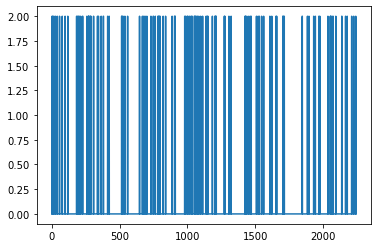

In [66]:
plt.plot(np.argmax(labels_predict, axis=1))

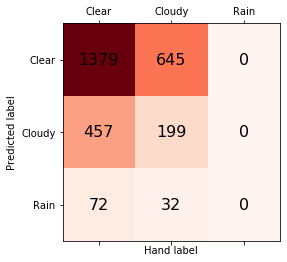

In [16]:
fig, ax = plt.subplots(1, 1)
ax.matshow(con_mat, cmap='Reds')
for (i, j), z in np.ndenumerate(con_mat):
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center', color='k', fontsize=16)

ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(['Clear', 'Cloudy', 'Rain'])
ax.set_yticklabels(['Clear', 'Cloudy', 'Rain'])
ax.set_xlabel('Hand label')
ax.set_ylabel('Predicted label')
fig.savefig('confusion_matrix_1layer_vgg19_oversample.png', dpi=300)

In [15]:
train_generator = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min/training',
                                                    class_mode='input', target_size=(1024, 128), shuffle=True,
                                                    batch_size=16)
valid_generator = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min/validation',
                                                    class_mode='input', 
                                                    target_size=(1024, 128), shuffle=True, batch_size=16)

Found 11132 images belonging to 3 classes.
Found 2922 images belonging to 3 classes.


In [28]:
def conv_net_encoder():
    ref_inp = Input(shape=(1024, 128, 3), name='snr')
      
    x = Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(ref_inp)
    l1 = Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_normal',  padding='same', activation='relu')(x)
    x = BatchNormalization()(l1)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    l2 = Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal',  padding='same', activation='relu')(x)
    x = BatchNormalization()(l2)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    l3 = Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(l3)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(8, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    l4 = Conv2D(8, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(l4)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(4, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    l5 = Conv2D(4, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(l5)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(2, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    l6 = Conv2D(2, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(l6)
    encode = MaxPooling2D((2,2), name='encoding')(x)
    
    x = Conv2DTranspose(2, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(encode)
    x = Conv2DTranspose(2, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(4, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = Conv2DTranspose(4, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(8, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = Conv2DTranspose(8, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = Conv2DTranspose(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    ref_out = Conv2DTranspose(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    ref_out = Conv2DTranspose(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(ref_out)
    ref_out = BatchNormalization()(ref_out)
    ref_out = UpSampling2D((2,2))(ref_out)
    ref_out = Conv2DTranspose(64, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(ref_out)
    ref_out = Conv2DTranspose(64, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(ref_out)
    ref_out = BatchNormalization()(ref_out)
    ref_out = UpSampling2D((2,2))(ref_out)
    ref_out = Conv2DTranspose(3, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(ref_out)
    return Model(ref_inp, ref_out)

In [29]:
autoencoder = conv_net_encoder()

In [30]:
autoencoder.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
snr (InputLayer)             [(None, 1024, 128, 3)]    0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 1024, 128, 64)     1792      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 1024, 128, 64)     36928     
_________________________________________________________________
batch_normalization_50 (Batc (None, 1024, 128, 64)     256       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 512, 64, 64)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 512, 64, 32)       18464     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 512, 64, 32)       9248

In [31]:
checkpointer = ModelCheckpoint(
               filepath=('/homes/rjackson/arming_the_edge/models/encoder-%dframes-{epoch:03d}.hdf5'),
               verbose=1)
autoencoder.fit(train_generator, validation_data=valid_generator, epochs=150, callbacks=[checkpointer], initial_epoch=0)

Epoch 1/150
696/696 [==============================] - 127s 180ms/step - loss: 0.3905 - val_loss: 0.0148

Epoch 00001: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-001.hdf5
Epoch 2/150
696/696 [==============================] - 126s 181ms/step - loss: 0.0088 - val_loss: 0.0049

Epoch 00002: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-002.hdf5
Epoch 3/150
696/696 [==============================] - 124s 179ms/step - loss: 0.0039 - val_loss: 0.0017

Epoch 00003: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-003.hdf5
Epoch 4/150
696/696 [==============================] - 125s 180ms/step - loss: 0.0068 - val_loss: 0.0038

Epoch 00004: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-004.hdf5
Epoch 5/150
696/696 [==============================] - 125s 179ms/step - loss: 0.0032 - val_loss: 0.0040

Epoch 00005: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-005.hdf5


696/696 [==============================] - 126s 181ms/step - loss: 0.0014 - val_loss: 8.9630e-04

Epoch 00041: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-041.hdf5
Epoch 42/150
696/696 [==============================] - 125s 179ms/step - loss: 0.0028 - val_loss: 9.3771e-04

Epoch 00042: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-042.hdf5
Epoch 43/150
696/696 [==============================] - 125s 180ms/step - loss: 0.0014 - val_loss: 8.7103e-04

Epoch 00043: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-043.hdf5
Epoch 44/150
696/696 [==============================] - 127s 183ms/step - loss: 0.0013 - val_loss: 0.0011

Epoch 00044: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-044.hdf5
Epoch 45/150
696/696 [==============================] - 169s 243ms/step - loss: 0.0012 - val_loss: 8.7371e-04

Epoch 00045: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-0

KeyboardInterrupt: 

In [24]:
encoder = load_model('/homes/rjackson/arming_the_edge/models/encoder-%dframes-055.hdf5')

OSError: SavedModel file does not exist at: /homes/rjackson/arming_the_edge/models/encoder-%dframes-055.hdf5/{saved_model.pbtxt|saved_model.pb}

In [24]:
with tf.device('/device:GPU:5'):
    pics = autoencoder.predict(train_generator.next())

In [35]:
encoder = Model(autoencoder.input, autoencoder.get_layer('encoding').output)

In [85]:
with tf.device('/device:GPU:6'):
    encodings = encoder.predict(train_generator)
    encodings_validation = encoder.predict(valid_generator)

In [87]:
encodings = np.reshape(encodings, (encodings.shape[0], encodings.shape[1]*encodings.shape[2]*encodings.shape[3]))
encodings_validation = np.reshape(encodings_validation, 
                                  (encodings_validation.shape[0],
                                   encodings_validation.shape[1]*encodings_validation.shape[2]*encodings_validation.shape[3]))

In [ ]:
encodings_validation = np.reshape(encodings_validation, 
                                  (encodings_validation.shape[0],
                                   encodings_validation.shape[1]*encodings_validation.shape[2]*encodings_validation.shape[3]))

In [88]:
encodings_valid = np.squeeze(np.argwhere(np.isfinite(np.sum(encodings, axis=1))))
encodings = encodings[encodings_valid, :]
encodings_valid = np.squeeze(np.argwhere(np.isfinite(np.sum(encodings_validation, axis=1))))
encodings_validation = encodings_validation[encodings_valid, :]

In [39]:
encodings.shape

(11132, 64)

In [95]:
train_labels = np.zeros((encodings.shape[0], 3))
valid_labels = np.zeros((encodings_validation.shape[0], 3))

for i in range(0, encodings.shape[0], 16):
    x, y = train_generator.next()
    num_y = y.shape[0]
    train_labels[i:i+num_y, :] = y[:num_y, :]
    
for i in range(0, encodings_validation.shape[0], 16):
    x, y = valid_generator.next()
    num_y = y.shape[0]
    valid_labels[i:i+num_y, :] = y[:num_y, :]

In [141]:
def nn_encodings():
    ref_inp = Input(shape=(64,), name='snr')
    x = ref_inp
    for i in range(10):
        x = Dense(2048, activation='relu')(x)
        x = Dropout(0.5)(x)
    out = Dense(3, activation='softmax')(x)
    return Model(ref_inp, out)

In [142]:
nn_classifier = nn_encodings()
nn_classifier.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
nn_classifier.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
snr (InputLayer)             [(None, 64)]              0         
_________________________________________________________________
dense_102 (Dense)            (None, 2048)              133120    
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_103 (Dense)            (None, 2048)              4196352   
_________________________________________________________________
dropout_16 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_104 (Dense)            (None, 2048)              4196352   
_________________________________________________________________
dropout_17 (Dropout)         (None, 2048)              0  

In [143]:
checkpointer = ModelCheckpoint(
               filepath=('/homes/rjackson/arming_the_edge/models/classifier-encodings-{epoch:03d}.hdf5'),
               verbose=1)
nn_classifier.fit(encodings, train_labels, validation_data=(encodings_validation, valid_labels), epochs=150,
                 callbacks=[checkpointer])

Epoch 1/150
348/348 [==============================] - 3s 6ms/step - loss: 0.8497 - accuracy: 0.6895 - val_loss: 0.7815 - val_accuracy: 0.6968

Epoch 00001: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-001.hdf5
Epoch 2/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7863 - accuracy: 0.6997 - val_loss: 0.7800 - val_accuracy: 0.6968

Epoch 00002: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-002.hdf5
Epoch 3/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7711 - accuracy: 0.7078 - val_loss: 0.7796 - val_accuracy: 0.6968

Epoch 00003: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-003.hdf5
Epoch 4/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7740 - accuracy: 0.6999 - val_loss: 0.7798 - val_accuracy: 0.6968

Epoch 00004: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-004.hdf5
Epoch 5/150
348/348 [===========

Epoch 35/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7763 - accuracy: 0.7030 - val_loss: 0.7799 - val_accuracy: 0.6968

Epoch 00035: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-035.hdf5
Epoch 36/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7678 - accuracy: 0.7024 - val_loss: 0.7800 - val_accuracy: 0.6968

Epoch 00036: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-036.hdf5
Epoch 37/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7650 - accuracy: 0.7048 - val_loss: 0.7818 - val_accuracy: 0.6968

Epoch 00037: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-037.hdf5
Epoch 38/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7602 - accuracy: 0.7092 - val_loss: 0.7796 - val_accuracy: 0.6968

Epoch 00038: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-038.hdf5
Epoch 39/150
348/348 [======

Epoch 69/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7630 - accuracy: 0.7115 - val_loss: 0.7812 - val_accuracy: 0.6968

Epoch 00069: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-069.hdf5
Epoch 70/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7709 - accuracy: 0.7034 - val_loss: 0.7792 - val_accuracy: 0.6968

Epoch 00070: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-070.hdf5
Epoch 71/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7661 - accuracy: 0.7057 - val_loss: 0.7795 - val_accuracy: 0.6968

Epoch 00071: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-071.hdf5
Epoch 72/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7678 - accuracy: 0.7047 - val_loss: 0.7793 - val_accuracy: 0.6968

Epoch 00072: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-072.hdf5
Epoch 73/150
348/348 [======

Epoch 103/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7623 - accuracy: 0.7082 - val_loss: 0.7795 - val_accuracy: 0.6968

Epoch 00103: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-103.hdf5
Epoch 104/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7674 - accuracy: 0.7041 - val_loss: 0.7800 - val_accuracy: 0.6968

Epoch 00104: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-104.hdf5
Epoch 105/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7723 - accuracy: 0.7022 - val_loss: 0.7793 - val_accuracy: 0.6968

Epoch 00105: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-105.hdf5
Epoch 106/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7647 - accuracy: 0.7044 - val_loss: 0.7800 - val_accuracy: 0.6968

Epoch 00106: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-106.hdf5
Epoch 107/150
348/348 [=


Epoch 00136: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-136.hdf5
Epoch 137/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7690 - accuracy: 0.7042 - val_loss: 0.7792 - val_accuracy: 0.6968

Epoch 00137: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-137.hdf5
Epoch 138/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7714 - accuracy: 0.7035 - val_loss: 0.7793 - val_accuracy: 0.6968

Epoch 00138: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-138.hdf5
Epoch 139/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7670 - accuracy: 0.7047 - val_loss: 0.7796 - val_accuracy: 0.6968

Epoch 00139: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-139.hdf5
Epoch 140/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7606 - accuracy: 0.7118 - val_loss: 0.7792 - val_accuracy: 0.6968

Epoch 00140: saving mod

In [ ]:
from sklearn.cluster import KMeans
SSE = np.zeros(20)

for i in range(1, 21):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(encodings)
    SSE[i-1] = kmeans.inertia_

Text(0, 0.5, 'Total squared error')

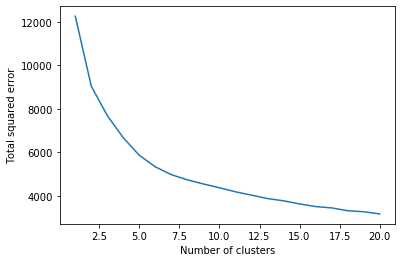

In [46]:
plt.plot(range(1, 21), SSE)
plt.xlabel('Number of clusters')
plt.ylabel('Total squared error')

In [47]:
num_classes = 5
kmeans = KMeans(n_clusters=num_classes)
kmeans.fit(encodings)
classes = kmeans.predict(encodings)

In [65]:
train_generator[1]

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

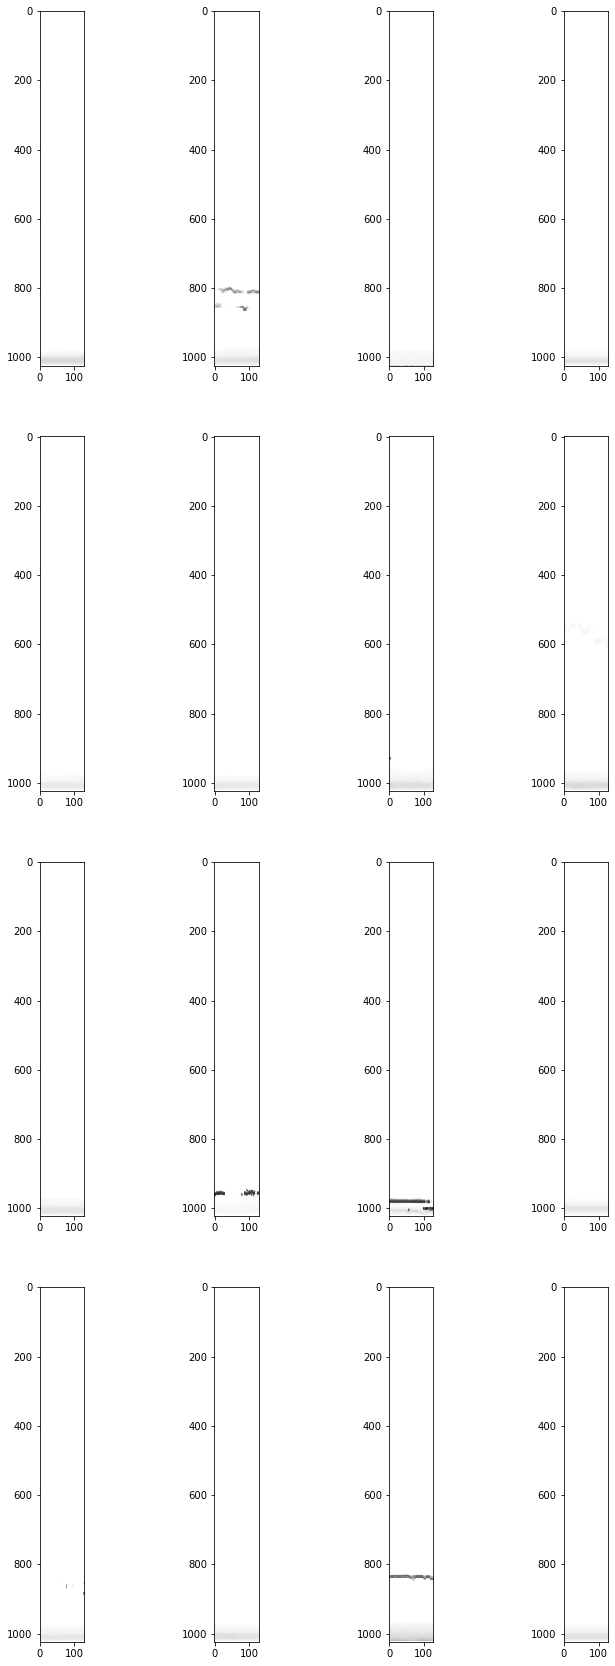

In [70]:
my_class = 2
where_class = np.argwhere(classes == my_class)
fig, ax = plt.subplots(4, 4, figsize=(12,30))
for i in range(16):
    ax[int(i / 4), i % 4].imshow(np.squeeze(train_generator[int(where_class[i] / 16)][0][where_class[i] % 16]))